### Imports

In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

### Initialize the LLM

In [2]:
load_dotenv()

groq_key = os.getenv("groq_api_key")
os.environ["GROQ_API_KEY"] = groq_key

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0
)

### Graph state

In [3]:
class State(TypedDict):
    topic: str
    joke_instructions: str
    joke: str
    improved_joke: str
    final_joke: str

### Nodes

In [4]:
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    prompt = f"""Write a short joke about {state['topic']}
    {state['joke_instructions']}"""
    
    msg = llm.invoke(prompt)
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""
    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

### Build workflow

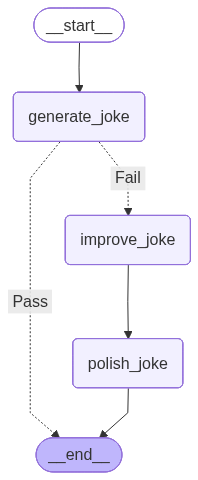

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xc6\x00\x00\x01\xe0\x08\x02\x00\x00\x00q{\x85\x95\x00\x00\x10\x00IDATx\x9c\xec\x9d\x07@\x13I\x17\xc7g\x93\xd0Bo\xd2QA\xb0\x80\x85\x13\xeb\xd9\xb1\xf7\xc2\xd9{\xef\r\xf4;{?{9\xdb\xd9\xcf\xde\xb1w=O=\xf4<+\nbC\x8a\x08\x82R\xa4\x06H\xfb^\xb2\x18#$\xb8\xab\xa9\x9b\xf9\x1d\x177\xb3\xb3\x9bM\xf6\xbfo\xde\xbci\x1c\xb1X\x8c0\x18\xd5\xc1A\x18\x8cJ\xc1\x92\xc2\xa8\x18,)\x8c\x8a\xc1\x92\xc2\xa8\x18,)\x8c\x8a\xc1\x92\xc2\xa8\x18\xdd\x92T\xf4\xfdO\tQ\xf99Y\xfc\xc2\\\xb1H\x1a\xdc \x08\x04Q\x0e\x16\x8b\x00D\x90&\xfa\x92\xc86b\x0b\xf9B\xc9[\x16"\xd3\xd9,\xc8#\x89\x8a\x10,\x82<\x9e\xc5\x86\xacH$\xdd&\x8f\x92$\x12\x927d\xa2\xf4\xf0\xe2\xcc\x844],\xfa\x12U\x81\x9c\xf0N>]v\x12\x19l\x0e\xe2\x18\xb3\xacl\x8d\xcaW3\xf3\xabo\x83\x0c\x1eB\x17\xe2Rw\xce||\xf9(7?G\x087\x8cc\x84\x8cM\x08\xb8\xcf,P\xca\xe7[\x08w\x1d\xc1}\x85k\x95JG\xba\x8d8\x1cB \x90\xde\xe6\xcf\x92Bl\x84D\x92]\xb2\x14\x16[\xf2N,\x14\xcb\x8e\x02\xc4\x84T|B\x99\xa4>\x1fNH\xe5#\x92\xbb2\x96\xf4\x84,8

In [5]:
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

# Save the workflow as image
chain.get_graph().draw_mermaid_png(output_file_path="chain_flow.png")

### Invoke

In [6]:
for node in chain.stream({"topic": "cats", "joke_instructions": "Always use ! or ? in the joke."}):
    print(node)

{'generate_joke': {'joke': 'Why did the cat join a band? Because it wanted to be the purr-cussionist!'}}


In [7]:
for node in chain.stream({"topic": "cats", "joke_instructions": "don't use ! or ? in the joke."}):
    print(node)

{'generate_joke': {'joke': 'Cats are like little landlords, they demand food and shelter in exchange for allowing you to share their space.'}}
{'improve_joke': {'improved_joke': 'That\'s a purr-fectly clever joke. Here\'s a revised version with some added wordplay:\n\n"Cats are like little landlords - they\'re the paw-fect example of a feline monopoly. They demand rent in the form of food and shelter, and in exchange, they grant you a lease on their affection, but only if you agree to their claw-ful terms and conditions. It\'s a cat-astrophic arrangement, but we\'re paws-itive we\'ll pay up, because let\'s face it, they\'re the purr-petual owners of the property... and our hearts."'}}
{'polish_joke': {'final_joke': 'That\'s a purr-fectly clever joke. Here\'s a revised version with some added wordplay and a surprising twist:\n\n"Cats are like little landlords - they\'re the paw-fect example of a feline monopoly. They demand rent in the form of food and shelter, and in exchange, they gra